<a href="https://colab.research.google.com/github/hughesymendes/TIC-27491137/blob/master/Exoplanet%20modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install lightkurve

     |████████████████████████████████| 501kB 2.8MB/s 
     |████████████████████████████████| 235kB 50.5MB/s 
     |████████████████████████████████| 4.5MB 49.3MB/s 
     |████████████████████████████████| 25.2MB 13.0MB/s 
     |████████████████████████████████| 2.7MB 44.6MB/s 
  Created wheel for oktopus: filename=oktopus-0.1.2-cp36-none-any.whl size=12779 sha256=a8b33c722a1feac8934a4ac9ffada26c640e19ddec8d80ff2b2073916c3619d1
  Stored in directory: /root/.cache/pip/wheels/9b/90/81/098fc66ee56166d63c9a8fc0a9672ae7b3423396a588ec952a
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96457 sha256=b5e50a7f02803ec1dc046ede21f2e3940cf8cbe81fb2c31099165e19016d7eae
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11376 sha256=6330b688ec293d33af157dad483608f47234e596a1443b84953afc56811a79a8
  Stored in directory: /root/.cache/pip/w

In [0]:
! pip install exoplanet

     |████████████████████████████████| 1.7MB 2.8MB/s 


The next cell is creating a random data set. For us this will be the data that TESS has taken and we've analysed. 

Initally we'll need to fit each transit individually so this data set will be the cadences for a snapshot of each transit

In [0]:


np.random.seed(42)

true_m = 0.25
true_b = 0
true_logs = np.log(0.2)

x = np.sort(np.random.uniform(0, 25, 500))
y = true_b + true_m * x + np.exp(true_logs) * np.random.randn(len(x))

plt.plot(x, y, ".k")
plt.ylim(0, 5)
plt.xlabel("x")
plt.ylabel("y")

Text(41.88338216145833, 0.5, 'y')

Next we need to model that data, using parameters that will return a trend like our dataset

In [0]:
#Trying to use the tutorial with some of our data plugged in to play with it 

import pymc3 as pm
with pm.Model() as model:

    # Define the priors on each parameter:
    m = pm.Uniform("m", lower=-5, upper=5)
    b = pm.Uniform("b", lower=-5, upper=5)
    logs = pm.Uniform("logs", lower=-5, upper=5)

    # Define the likelihood. A few comments:
    #  1. For mathematical operations like "exp", you can't use
    #     numpy. Instead, use the mathematical operations defined
    #     in "pm.math".
    #  2. To condition on data, you use the "observed" keyword
    #     argument to any distribution. In this case, we want to
    #     use the "Normal" distribution (look up the docs for
    #     this).
    pm.Normal("obs", mu=m * x + b, sd=pm.math.exp(logs), observed=y)

    # This is how you will sample the model. Take a look at the
    # docs to see that other parameters that are available.
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs, b, m]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 417.95draws/s]


From here we could plot this model and try to fit it to our dataset


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


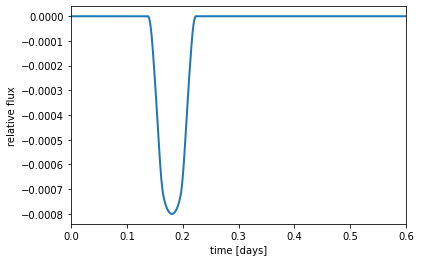

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=9, t0 =0.1805556, b =0.897, r_star = 0.78, m_star = 0.78)

# Compute a limb-darkened light curve using starry
t = np.linspace(0, 0.6, 1000)
#found values from an old paper for Kepler and TESS that gives a=0.4984, b= 0.1939 (using quadratic law).
# 'u' seems to be linear but is only given as one value whereas u here is 2D so ive input values 
# In between the two closest stellar temps. paper-- https://arxiv.org/pdf/0912.2274.pdf
u = [0.525, 0.215]
light_curve = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.02466, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

In [0]:
import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import matplotlib.pyplot as plt
import numpy as np

In [0]:
tpf = search_targetpixelfile("TIC 27491137").download()

In [0]:
aper = tpf.create_threshold_mask()
tpf.plot(aperture_mask = aper, mask_color = "red")

In [0]:
lc = tpf.to_lightcurve()

mask = np.isfinite(lc.flux_err)
clipped = lc[mask]

clipped.plot()

In [0]:
clipped[3200:4000].plot()

In [0]:
#These should be ammended float64 arrays of the data points for one of the transits (dip 1)

d1x = np.append( np.array( [clipped.time], dtype="float64" ),clipped.time )
d1y = np.append( np.array( [clipped.flux], dtype="float64" ), clipped.flux )
d1y_err = np.append( np.array( [clipped.flux_err], dtype="float64" ), clipped.flux_err )

In [0]:
#This is just creating some random dataset for a transit, copied from the tutorial for practise

np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

In [0]:
#This is where i need to implement my dataset to model each transit

import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform(
        "r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06])
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=np.random.rand(2)
    )

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

TypeError: ignored